In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, adjusted_rand_score
from time import time
from yellowbrick.cluster import KElbowVisualizer
from numpy import arange
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd

# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Data load

In [3]:
X = pd.read_csv('olist_clients.csv', sep=',', decimal='.',
                encoding='utf8', low_memory=False)
print(X.shape)

(92746, 12)


# Transformers

In [4]:
transformer_list = list()
transformer_list.append(('None', None))
transformer_list.append(('MinMaxScaler', MinMaxScaler()))
transformer_list.append(('MaxAbsScaler', MaxAbsScaler()))
transformer_list.append(('StandardScaler', StandardScaler()))
transformer_list.append(('QuantileTransformer', QuantileTransformer()))
transformer_list.append(('Normalizer', Normalizer()))
transformer_list.append(('PowerTransformer', PowerTransformer()))

# Evaluation KMeans

In [5]:
# Metrics
# silhouette, calinski_harabasz
metrics = ['distortion']
compare = list()


def evaluate(transformer_name, X_transformed):
    for metric in metrics:
        print('')
        print('Start: ', time.asctime())
        print('KElbowVisualizer metric:', metric)

        # Méthode du coude pour déterminer la meilleure valeur de k
        KEV = KElbowVisualizer(KMeans(), k=(
            3, 12), metric=metric, timings=False, show=False)
        KElbowVisu = KEV.fit(X_transformed)

        if not KElbowVisu.elbow_value_ == None:
            # Calcul du silhouette_score
            model = KMeans(n_clusters=KElbowVisu.elbow_value_, random_state=0)
            cluster_labels = model.fit_predict(X_transformed)
            silhouette_avg = silhouette_score(X_transformed, cluster_labels)

            print('Best silhouette_score for n_clusters =', KElbowVisu.elbow_value_,
                  ' :', silhouette_avg,)

            # Stockage du résultat
            name = transformer_name + '_' + metric + \
                '_k_' + str(KElbowVisu.elbow_value_)
            compare.append((name, silhouette_avg))
        else:
            print('KElbowVisualizer ne donne pas de k')

        print('End: ', time.asctime())
        print('')

-------------------------------------------------------
Transformer:  None
-------------------------------------------------------

Start:  Wed Jan 19 16:38:46 2022
KElbowVisualizer metric: distortion
Best silhouette_score for n_clusters = 6  : 0.4377662661961089
End:  Wed Jan 19 16:40:03 2022

-------------------------------------------------------
Transformer:  MinMaxScaler
-------------------------------------------------------

Start:  Wed Jan 19 16:40:03 2022
KElbowVisualizer metric: distortion
Best silhouette_score for n_clusters = 7  : 0.27619533977762556
End:  Wed Jan 19 16:41:16 2022

-------------------------------------------------------
Transformer:  MaxAbsScaler
-------------------------------------------------------

Start:  Wed Jan 19 16:41:16 2022
KElbowVisualizer metric: distortion
Best silhouette_score for n_clusters = 6  : 0.28650093609050503
End:  Wed Jan 19 16:42:29 2022

-------------------------------------------------------
Transformer:  StandardScaler
---------

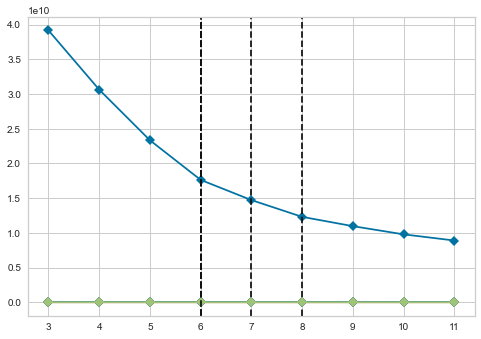

In [6]:
for transformer_name, transformer in transformer_list:
    print('-------------------------------------------------------')
    print('Transformer: ', transformer_name)
    print('-------------------------------------------------------')

    if 'None' in transformer_name:
        evaluate(transformer_name, X)

    elif 'StandardScaler' in transformer_name:
        print('Sans PCA')
        X_transformed = transformer.fit_transform(X)
        evaluate(transformer_name, X_transformed)

        print('Avec PCA')
        for n_components in arange(2, X.shape[1], 1):
            print('************************')
            print('n_components', n_components)
            pca = PCA(n_components=n_components)

            X_PCA = pca.fit_transform(X_transformed)

            print('Explained variance :', pca.explained_variance_ratio_.sum())

            if pca.explained_variance_ratio_.sum() > 0.95:
                evaluate(transformer_name + '_pca_' + str(n_components), X_PCA)
            else:
                print('Non évalué')

            print('')

    else:
        X_transformed = transformer.fit_transform(X)
        evaluate(transformer_name, X_transformed)

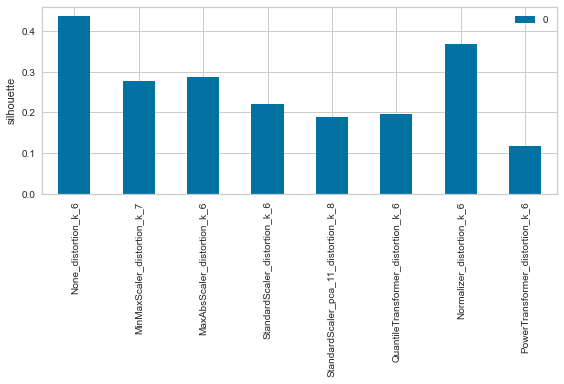

In [7]:
results = {}

for name, silhouette in compare:
    results[name] = silhouette

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.plot(kind='bar', ylabel='silhouette')
plt.tight_layout()
plt.gcf().savefig('eval_kmeans', dpi=100)
plt.show()

# Select best model

In [8]:
transformer_list.pop(6)
transformer_list.pop(4)
transformer_list.pop(3)
transformer_list.pop(2)
transformer_list.pop(1)

('MinMaxScaler', MinMaxScaler())

In [9]:
transformer_list

[('None', None), ('Normalizer', Normalizer())]

## Evaluate the best k

-------------------------------------------------------
None
-------------------------------------------------------
Start:  Wed Jan 19 16:48:37 2022


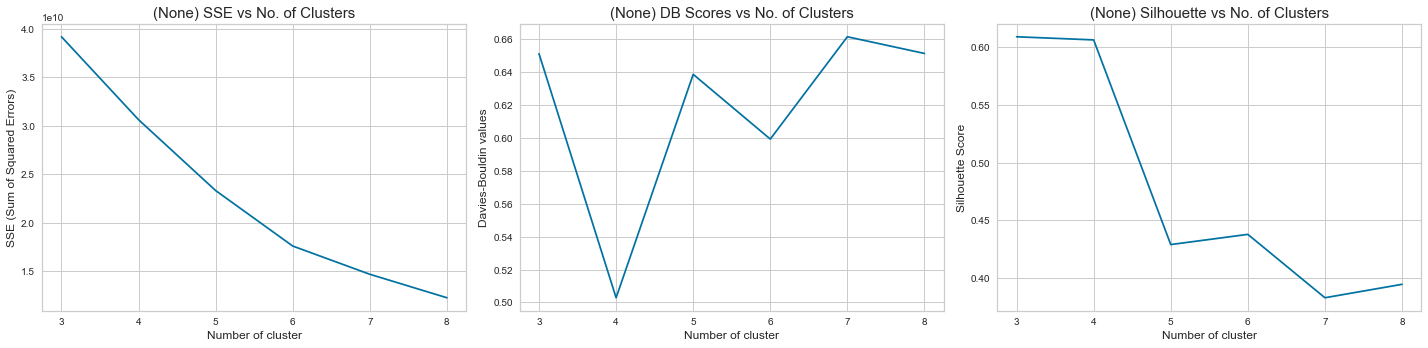

End:  Wed Jan 19 16:56:22 2022
-------------------------------------------------------
Normalizer
-------------------------------------------------------
Start:  Wed Jan 19 16:56:22 2022


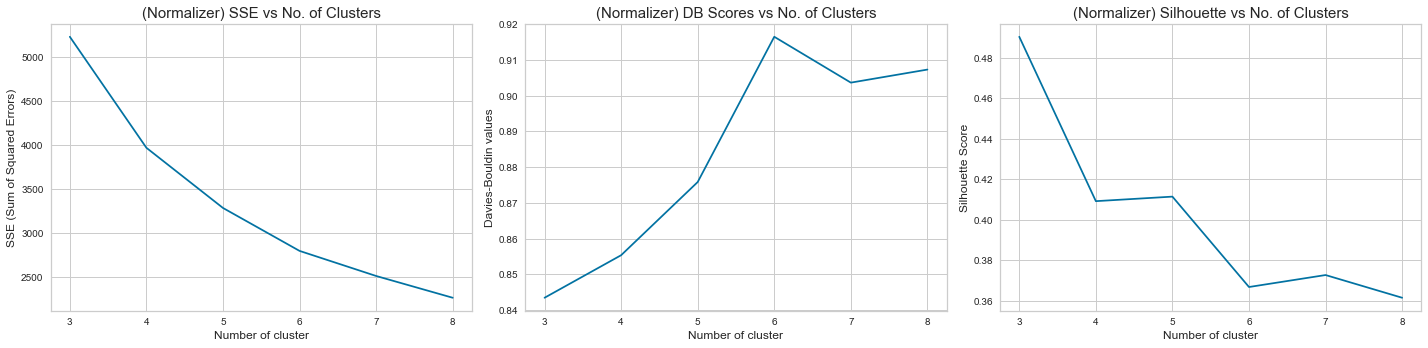

End:  Wed Jan 19 17:03:35 2022


In [10]:
sse, db, slc = {}, {}, {}

for transformer_name, transformer in transformer_list:
    print('-------------------------------------------------------')
    print(transformer_name)
    print('-------------------------------------------------------')

    sse.clear()
    db.clear()
    slc.clear()

    # Transformer
    if 'None' in transformer_name:
        X_transformed = X
    else:
        X_transformed = transformer.fit_transform(X)

    print('Start: ', time.asctime())

    # K evaluation
    for k in range(3, 9):
        model = KMeans(n_clusters=k, random_state=0)
        model.fit_predict(X_transformed)

        clusters = model.labels_

        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = model.inertia_
        db[k] = davies_bouldin_score(X_transformed, clusters)
        slc[k] = silhouette_score(X_transformed, clusters)

    # Display results
    fig = plt.figure(figsize=(20, 5))

    ax = fig.add_subplot(1, 3, 1)
    ax.plot(list(sse.keys()), list(sse.values()))
    ax.set_xlabel('Number of cluster', fontsize=12)
    ax.set_ylabel('SSE (Sum of Squared Errors)', fontsize=12)
    ax.set_title('(' + transformer_name +
                 ') SSE vs No. of Clusters', fontsize=15)

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(list(db.keys()), list(db.values()))
    ax.set_xlabel('Number of cluster', fontsize=12)
    ax.set_ylabel('Davies-Bouldin values', fontsize=12)
    ax.set_title('(' + transformer_name +
                 ') DB Scores vs No. of Clusters', fontsize=15)

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(list(slc.keys()), list(slc.values()))
    ax.set_xlabel('Number of cluster', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title('(' + transformer_name +
                 ') Silhouette vs No. of Clusters', fontsize=15)

    plt.tight_layout()
    plt.gcf().savefig('meilleur_k_' + transformer_name, dpi=100)
    plt.show()

    print('End: ', time.asctime())

## Initialisation stability

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
None		4	10		0.9987461035600532
None		4	20		1.0
None		4	30		0.9972635775283766
None		4	40		1.0
None		4	50		1.0
None		4	60		1.0
None		4	70		1.0
None		4	80		1.0
None		4	90		0.33557562271911046
None		4	100		1.0
____________________________________________________________________________________________________________


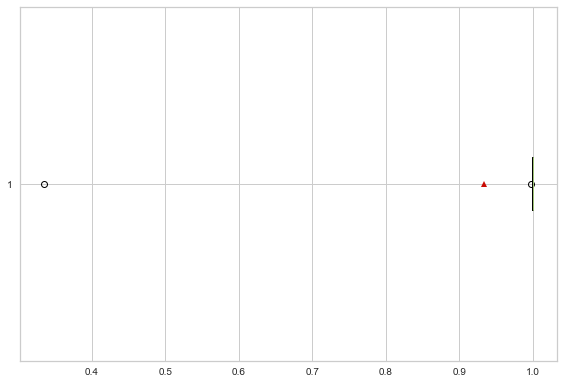

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
None		5	10		0.9992030129792897
None		5	20		0.9992030129792897
None		5	30		0.9991631728888849
None		5	40		0.9998007201725665
None		5	50		0.9991631728888849
None		5	60		0.9992030129792897
None		5	70		0.9998237966279567
None		5	80		0.9972812309652701
None		5	90		0.9977789098911974
None		5	100		0.9990834953541339
____________________________________________________________________________________________________________


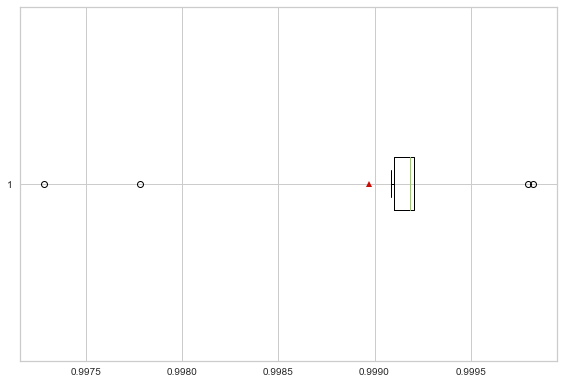

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
None		6	10		0.9921214523248
None		6	20		0.99314433526928
None		6	30		0.9911144543647074
None		6	40		0.9902797779591775
None		6	50		0.9910979349621354
None		6	60		0.9910979349621354
None		6	70		0.9909009442679655
None		6	80		0.991736087711449
None		6	90		0.9912657046079058
None		6	100		0.99269391500099
____________________________________________________________________________________________________________


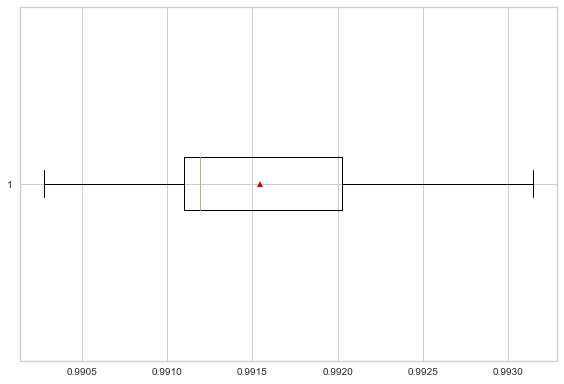

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
Normalizer		4	10		0.9963595416788062
Normalizer		4	20		0.9969133280780147
Normalizer		4	30		0.9949666345328105
Normalizer		4	40		0.9979278610824383
Normalizer		4	50		0.997132032666696
Normalizer		4	60		0.9964347677125992
Normalizer		4	70		0.9931026764962975
Normalizer		4	80		0.995532144569649
Normalizer		4	90		0.9972080691041255
Normalizer		4	100		0.9971133852174661
____________________________________________________________________________________________________________


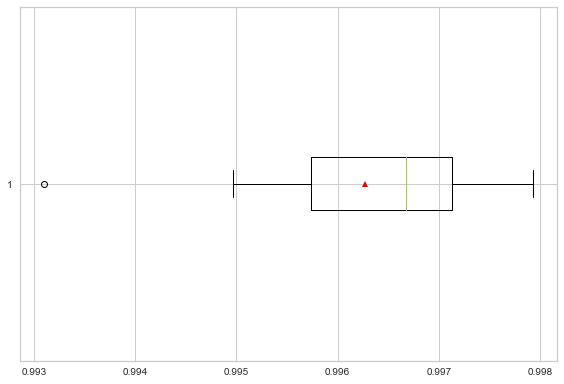

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
Normalizer		5	10		0.9944920992550349
Normalizer		5	20		0.9976873619434891
Normalizer		5	30		0.9950825726134751
Normalizer		5	40		0.9962388298638513
Normalizer		5	50		0.9926094459937015
Normalizer		5	60		0.9961818380026036
Normalizer		5	70		0.9922984622537507
Normalizer		5	80		0.9955678459913598
Normalizer		5	90		0.9940388432563511
Normalizer		5	100		0.9950950277111061
____________________________________________________________________________________________________________


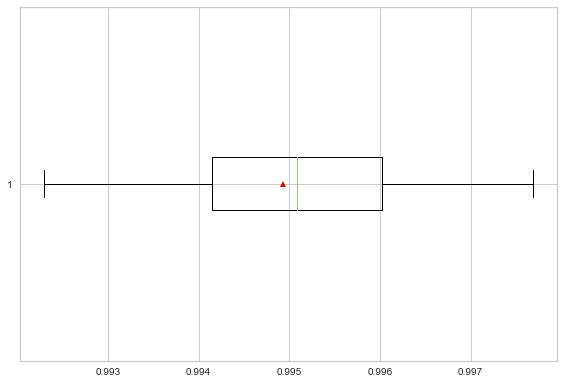

____________________________________________________________________________________________________________
transformer	k	random_state	ARI
____________________________________________________________________________________________________________
Normalizer		6	10		0.9915885647229454
Normalizer		6	20		0.9920667654260774
Normalizer		6	30		0.9957896405088221
Normalizer		6	40		0.9965635306053794
Normalizer		6	50		0.9922573326107881
Normalizer		6	60		0.9945925590981423
Normalizer		6	70		0.9951997173504933
Normalizer		6	80		0.9953150073509031
Normalizer		6	90		0.9910937574303351
Normalizer		6	100		0.9946599957906987
____________________________________________________________________________________________________________


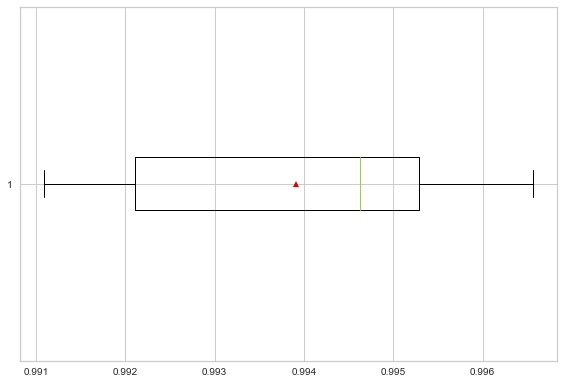

In [11]:
for transformer_name, transformer in transformer_list:
    # Transformer
    if 'None' in transformer_name:
        X_transformed = X
    else:
        X_transformed = transformer.fit_transform(X)

    # k variation
    for n_clusters_final in range(4, 7):
        KMeans_0 = KMeans(n_clusters=n_clusters_final, random_state=0)
        clusters = KMeans_0.fit_predict(X_transformed)

        print(108 * "_")
        print('transformer\tk\trandom_state\tARI')
        print(108 * "_")

        ari_tab = {}

        # random_state variation
        for random in arange(10, 101, 10):
            kmeans = KMeans(n_clusters=n_clusters_final, random_state=random)
            kmeans.fit_predict(X_transformed)

            ari = adjusted_rand_score(KMeans_0.labels_, kmeans.labels_)
            ari_tab[random] = ari
            print(transformer_name + '\t\t' + str(n_clusters_final) +
                  '\t' + str(random) + '\t\t' + str(ari))

        print(108 * "_")

        plt.boxplot(list(ari_tab.values()),
                    showfliers=True, vert=False, showmeans=True)
        plt.tight_layout()
        plt.gcf().savefig('stabilité_' + transformer_name +
                          '_' + str(n_clusters_final), dpi=100)
        plt.show()

# Business interpretation

In [12]:
KMeans_final = KMeans(n_clusters=5, random_state=0)

In [13]:
clusters = KMeans_final.fit_predict(X)

In [14]:
output = pd.DataFrame(data=clusters)
barplot = output[0].value_counts(ascending=False)
barplot

3    56614
0    28893
1     7107
4      131
2        1
Name: 0, dtype: int64

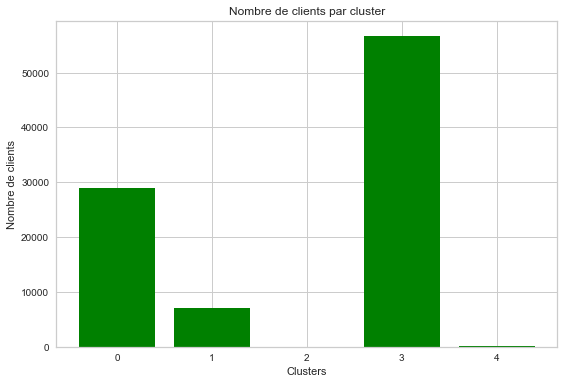

In [15]:
plt.bar(barplot.index, barplot.values, color='green')
plt.xlabel("Clusters")
plt.ylabel("Nombre de clients")
plt.title("Nombre de clients par cluster")
plt.tight_layout()
plt.gcf().savefig('barplot_clients_cluster', dpi=100)
plt.show()

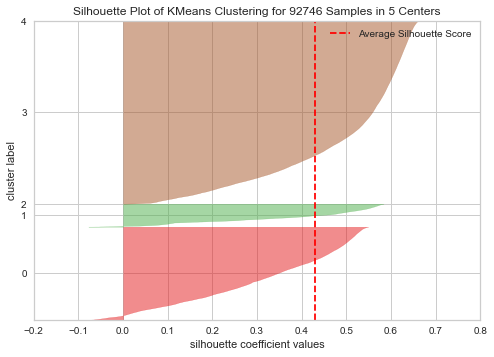

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92746 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
model = SilhouetteVisualizer(KMeans_final)
model.fit(X)
model.show()

In [17]:
X_eval = X.copy()

In [18]:
X_eval['cluster'] = KMeans_final.labels_

In [19]:
X_eval.columns

Index(['recency', 'total_orders', 'total_products', 'total_value',
       'total_payment_types', 'total_payment_installments',
       'mean_delivery_delay', 'mean_review_score',
       'mean_review_message_length', 'mean_review_answer_delay',
       'mean_product_desc_length', 'mean_product_photos_qty', 'cluster'],
      dtype='object')

In [20]:
X_eval = X_eval.groupby('cluster')['recency', 'total_orders', 'total_products', 'total_value',
                                   'total_payment_types', 'total_payment_installments', 'mean_delivery_delay',
                                   'mean_review_score', 'mean_review_message_length', 'mean_review_answer_delay',
                                   'mean_product_desc_length', 'mean_product_photos_qty'].mean()

In [21]:
X_eval.head()

,recency,total_orders,total_products,total_value,total_payment_types,total_payment_installments,mean_delivery_delay,mean_review_score,mean_review_message_length,mean_review_answer_delay,mean_product_desc_length,mean_product_photos_qty
cluster,,,,,,,,,,,,
0,229.865452,1.033918,1.059703,228.693270,1.025335,1.230402,-11.940823,4.162868,27.639455,2.577754,1149.598812,2.492802
1,224.808227,1.019699,1.028845,313.482512,1.023357,1.185451,-11.778203,4.204500,26.927278,2.733256,2570.558540,2.642692
2,334.000000,1.000000,1.000000,109312.640000,1.000000,8.000000,-6.000000,1.000000,65.000000,1.000000,2532.000000,3.000000
3,244.888872,1.034196,1.076571,167.966808,1.027060,1.235949,-11.871055,4.144378,27.358122,2.571195,451.265216,2.036354
4,230.268560,1.160305,1.595420,9272.955267,1.007634,6.839695,-13.047431,3.192330,44.263104,2.428253,1135.371344,2.013615


In [22]:
scaler = MinMaxScaler(feature_range=(1, 5))
X_eval_scaled = scaler.fit_transform(X_eval)

## Cluster 0

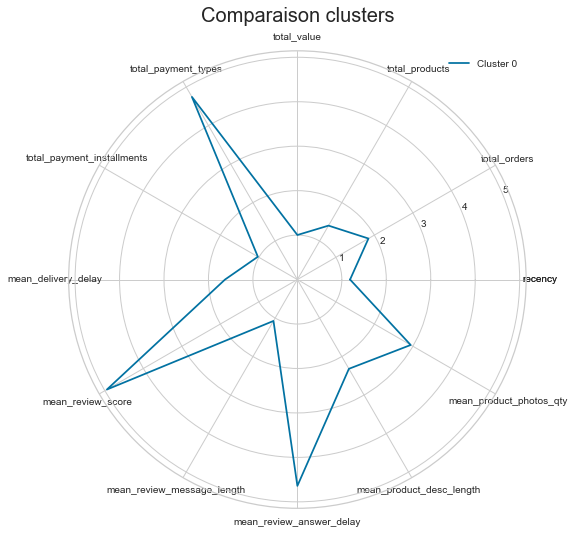

In [23]:
categories = X_eval.columns
categories = [*categories, categories[0]]

cluster = X_eval_scaled[0]
cluster = [*cluster, cluster[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster, label='Cluster ' + str(0))
plt.title('Comparaison clusters', size=20, y=1.05)
lines, labels = plt.thetagrids(
    [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 0], labels=categories)
plt.legend()
plt.tight_layout()
plt.gcf().savefig('Cluster 0', dpi=100)
plt.show()

## Cluster 1

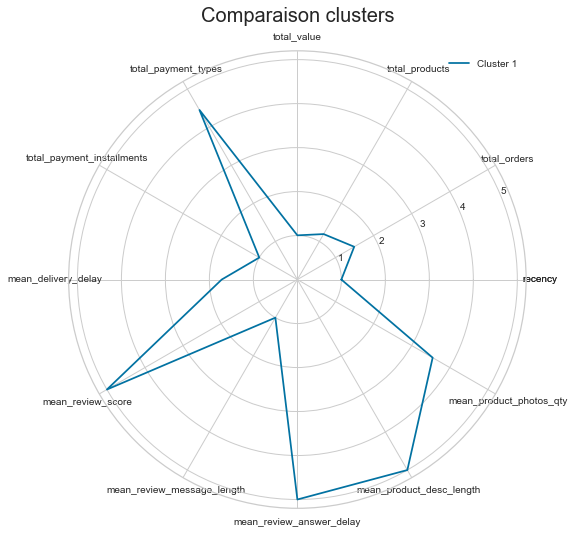

In [24]:
categories = X_eval.columns
categories = [*categories, categories[0]]

cluster = X_eval_scaled[1]
cluster = [*cluster, cluster[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster, label='Cluster ' + str(1))
plt.title('Comparaison clusters', size=20, y=1.05)
lines, labels = plt.thetagrids(
    [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 0], labels=categories)
plt.legend()
plt.tight_layout()
plt.gcf().savefig('Cluster 1', dpi=100)
plt.show()

## Cluster 2

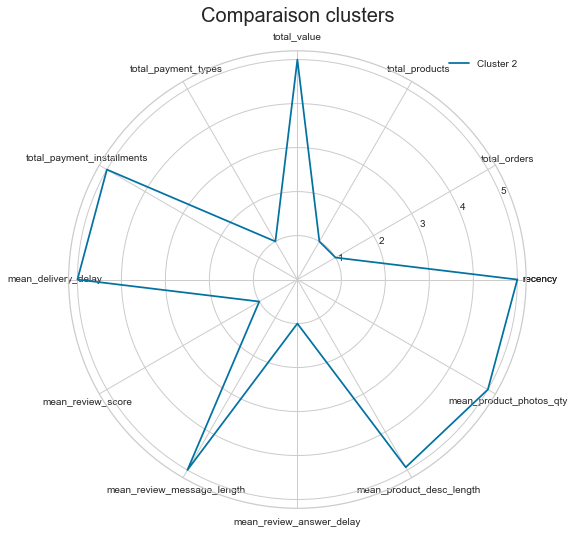

In [25]:
categories = X_eval.columns
categories = [*categories, categories[0]]

cluster = X_eval_scaled[2]
cluster = [*cluster, cluster[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster, label='Cluster ' + str(2))
plt.title('Comparaison clusters', size=20, y=1.05)
lines, labels = plt.thetagrids(
    [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 0], labels=categories)
plt.legend()
plt.tight_layout()
plt.gcf().savefig('Cluster 2', dpi=100)
plt.show()

## Cluster 3

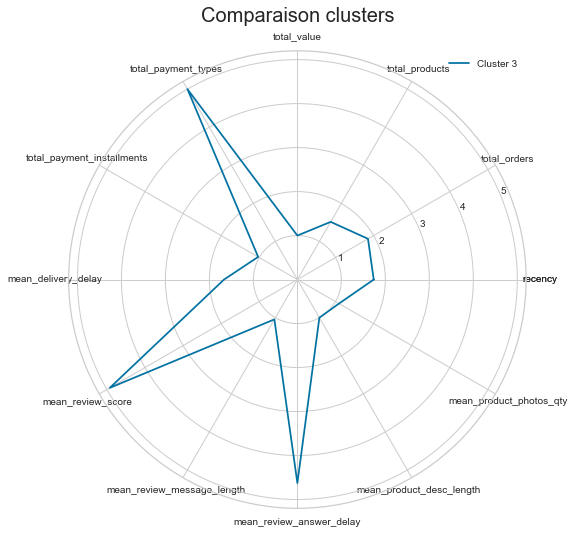

In [26]:
categories = X_eval.columns
categories = [*categories, categories[0]]

cluster = X_eval_scaled[3]
cluster = [*cluster, cluster[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster, label='Cluster ' + str(3))
plt.title('Comparaison clusters', size=20, y=1.05)
lines, labels = plt.thetagrids(
    [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 0], labels=categories)
plt.legend()
plt.tight_layout()
plt.gcf().savefig('Cluster 3', dpi=100)
plt.show()

## Cluster 4

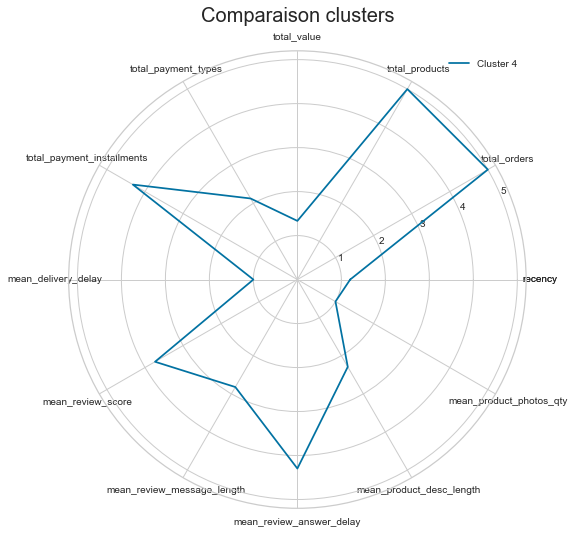

In [27]:
categories = X_eval.columns
categories = [*categories, categories[0]]

cluster = X_eval_scaled[4]
cluster = [*cluster, cluster[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, cluster, label='Cluster ' + str(4))
plt.title('Comparaison clusters', size=20, y=1.05)
lines, labels = plt.thetagrids(
    [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 0], labels=categories)
plt.legend()
plt.tight_layout()
plt.gcf().savefig('Cluster 4', dpi=100)
plt.show()